<a href="https://colab.research.google.com/github/Shruti-Bibra/Neural-Voice-Cloning/blob/main/Neural_Voice_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q gradio
!pip install -q openai
!pip install -q gTTS
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import IPython.display as ipd
ipd.Audio('1.wav')

In [ ]:
y, sr = librosa.load('1.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

In [ ]:
 y

array([ 8.7990679e-07, -1.7809839e-06,  1.3038599e-05, ...,
       -4.2947254e-04, -7.5020216e-06,  2.6077818e-04], dtype=float32)

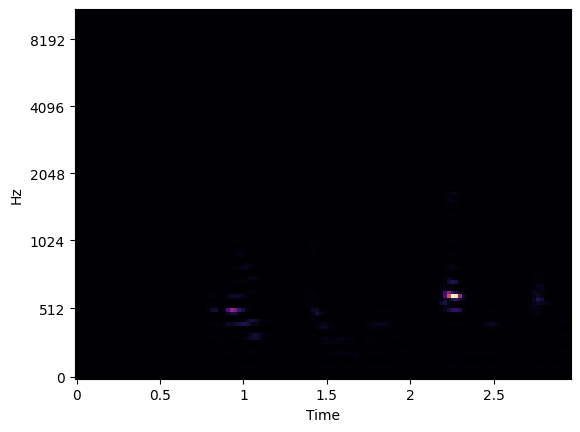

In [ ]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

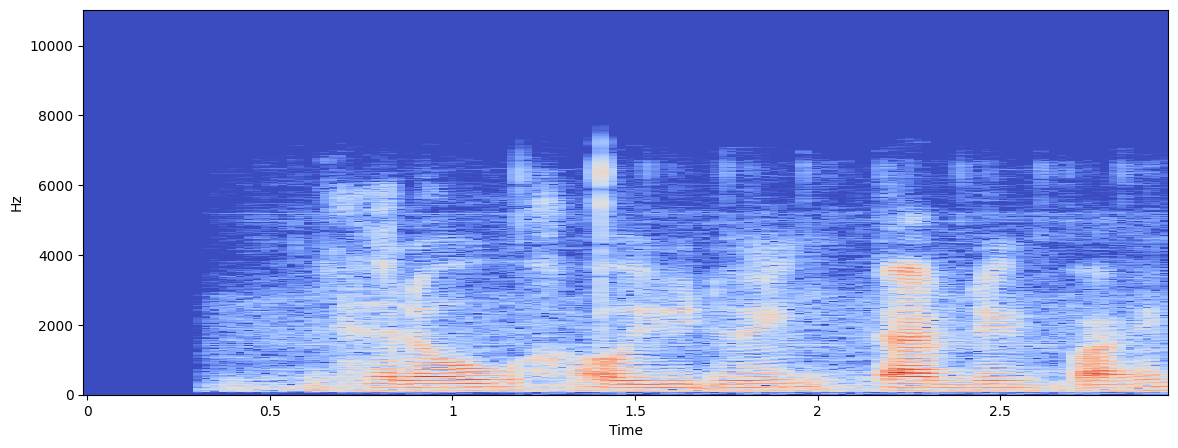

In [ ]:
x= librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(x))
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [ ]:
import whisper
import gradio as gr
import time
import warnings
import json
import openai
import os
from gtts import gTTS

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
with open('GPT_SECRET_KEY.json') as f:
    data = json.load(f)

In [ ]:
openai.api_key = data["api_key"]

In [ ]:
model = whisper.load_model("base")

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
!ffmpeg -f lavfi -i anullsrc=r=44100:cl=mono -t 10 -q:a 9 -acodec libmp3lame Temp.mp3

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [ ]:
def chatgpt_api(input_text):
    messages = [
    {"role": "system", "content": "You are a helpful assistant."}]

    if input_text:
        messages.append(
            {"role": "user", "content": input_text},
        )
        chat_completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo", messages=messages
        )

    reply = chat_completion.choices[0].message.content
    return reply

In [ ]:
def transcribe(audio):

    language = 'en'

    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)

    mel = whisper.log_mel_spectrogram(audio).to(model.device)

    _, probs = model.detect_language(mel)

    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    result_text = result.text

    out_result = chatgpt_api(result_text)

    audioobj = gTTS(text = out_result,
                    lang = language,
                    slow = False)

    audioobj.save("Temp.mp3")

    return [result_text, out_result, "Temp.mp3"]

In [ ]:
output_1 = gr.Textbox(label="Speech to Text")
output_2 = gr.Textbox(label="ChatGPT Output")
output_3 = gr.Audio("Temp.mp3")

gr.Interface(
    title = 'Neural voice cloning Bot',
    fn=transcribe,
    inputs=[
        gr.inputs.Audio(source="microphone", type="filepath")
    ],

    outputs=[
        output_1,  output_2, output_3
    ],
    live=True).launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>